# 🌽 Projeto: Análise Estratégica da Dinâmica de Preços da Soja (Data Analytics)

O agronegócio é um dos setores mais ricos em dados e um pilar da economia brasileira. Vamos estruturar um projeto de ponta a ponta, usando como exemplo a Previsão de Preços de Commodities Agrícolas (ex: Soja).

A Análise de Dados foca em explicar o passado e o presente para dar suporte à tomada de decisão (Descriptive e Diagnostic).

O objetivo será **"quais fatores historicamente influenciam o preço e quais são os padrões de comportamento da commodity?"**.

Utilizaremos a mesma metodologia **CRISP-DM**, mas com foco em insights de negócio e visualização.

## 1. Entendimento do Negócio (Business Understanding)

Mudamos o foco da incerteza futura para a compreensão de padrões históricos.

* **Problema de Negócio:** Produtores e gestores têm dificuldade em visualizar a correlação real entre o câmbio, a safra e o preço da soja. Muitas decisões são tomadas com base em "feeling" e não em dados concretos sobre sazonalidade e tendências.

* **Objetivo da Análise:** Desenvolver um Dashboard Estratégico que permita responder:

   * Qual é a real correlação entre o Dólar e a Soja no longo prazo?

   * Existe um padrão sazonal claro (ex: queda de preços) durante os meses de colheita?

   * Como as quebras de safra passadas impactaram a volatilidade do preço?

* **KPIs (Indicadores Chave):**

   * Preço Médio Mensal/Anual.

   * Variação Percentual (MoM - Month over Month e YoY - Year over Year).

   * Volatilidade (Desvio Padrão do preço no período).

## 2. Entendimento dos Dados (Data Understanding)

* **Fontes de Dados:**

   * Preço da Soja (CEPEA/Esalq): Foco na série histórica longa (últimos 5 a 10 anos).

   * Macroeconomia (BACEN): Dólar PTAX (Venda).

   * Safra (CONAB): Dados históricos de produção (milhões de toneladas) e área plantada.

* **Perguntas para a Análise Exploratória (EDA):**

   * Qualidade: Existem buracos na série histórica do CEPEA?

   * Distribuição: Qual foi o preço mínimo, máximo e médio em cada ano?

   * Outliers: Houve picos de preço anormais? O que aconteceu nessas datas (ex: Pandemia, Guerra)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

# Configuração visual para ficar bonito
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Ambiente configurado com sucesso!")

Ambiente configurado com sucesso!


### 🚜 Trazendo os Dados (O Desafio)

No mundo real, os dados não estão prontos. Vamos lidar com duas realidades diferentes aqui: Dados Públicos via API (Fácil) e Dados em Arquivos Excel (Trabalhoso).

**Tarefa A: O Dólar (Automático via Código)**

O Banco Central do Brasil tem uma API aberta. Não precisamos baixar arquivo nenhum. O Pandas consegue ler direto da internet.

Iniciando download via Yahoo Finance...
✅ Carga do Dólar finalizada. Registros: 2062


,data,dolar_ptax
542,2018-01-01,3.3076
543,2018-01-02,3.3110
544,2018-01-03,3.2578
545,2018-01-04,3.2355
546,2018-01-05,3.2331


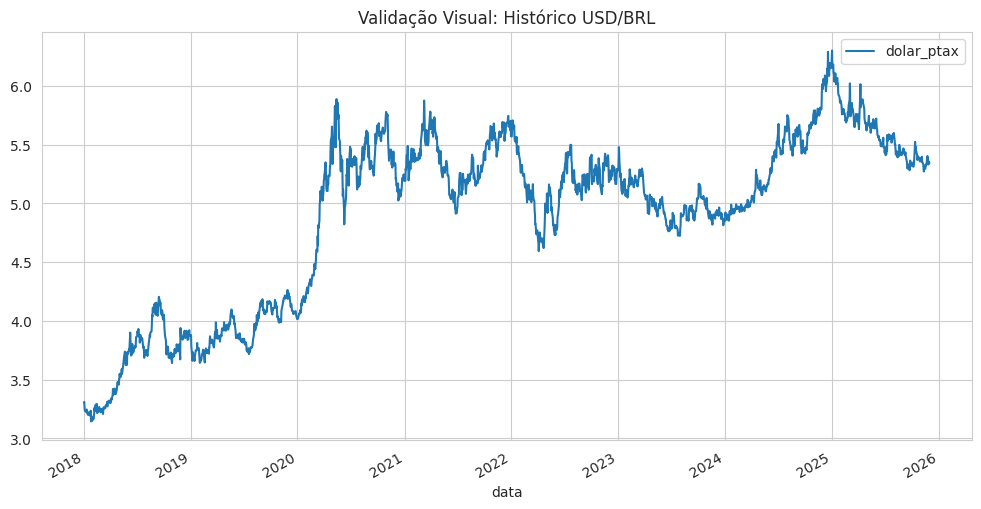

In [2]:
# Instalação silenciosa da lib de mercado financeiro (caso não exista no env)
!pip install yfinance -q

import yfinance as yf
import pandas as pd

# -----------------------------------------------------------------------------
# Estratégia de Ingestão de Dados:
# O endpoint do BACEN apresenta instabilidade com IPs de Cloud (Erro 406/Geo-blocking).
# Decisão: Pivotar para API do Yahoo Finance (yfinance), que é robusta para dados de FX.
# Ticker: 'BRL=X' (Taxa de Câmbio USD/BRL)
# -----------------------------------------------------------------------------

try:
    print("Iniciando download via Yahoo Finance...")
    
    # Baixando histórico máximo com intervalo diário
    # auto_adjust=True corrige splits e dividendos (não aplicável a moeda, mas boa prática)
    ticker = yf.Ticker("BRL=X")
    df_dolar = ticker.history(period="10y", interval="1d", auto_adjust=True)

    # Resetando index para transformar a Data (que vem como índice) em coluna
    df_dolar = df_dolar.reset_index()

    # Pipeline de Limpeza (Data Cleaning):
    # 1. Padronização de nomes para manter compatibilidade com o resto do código
    # 2. Remoção de timezone (UTC) para evitar conflitos com dados locais (CEPEA)
    df_dolar = df_dolar.rename(columns={'Date': 'data', 'Close': 'dolar_ptax'})
    df_dolar['data'] = df_dolar['data'].dt.tz_localize(None)

    # Seleção de Features: Mantemos apenas a data e o preço de fechamento (Close)
    # O 'Close' do Yahoo é a referência de mercado mais próxima da PTAX para análise macro
    df_dolar = df_dolar[['data', 'dolar_ptax']]

    # Recorte temporal: Foco na análise recente (2018+)
    df_dolar = df_dolar[df_dolar['data'] >= '2018-01-01']

    print(f"✅ Carga do Dólar finalizada. Registros: {df_dolar.shape[0]}")
    display(df_dolar.head())
    
    # Plot rápido para validação visual da integridade dos dados
    df_dolar.plot(x='data', y='dolar_ptax', title='Validação Visual: Histórico USD/BRL')

except Exception as e:
    print(f"❌ Falha crítica na ingestão: {e}")


### Tarefa B: A Soja (Upload Manual - Vida Real)
O CEPEA (Esalq) disponibiliza os dados em Excel/HTML, e eles protegem contra robôs, então o código direto costuma falhar. Você terá que fazer o papel do Analista de Dados que baixa o arquivo.

Acesse o site do CEPEA: Cepea Soja. https://www.cepea.org.br/br/busca.aspx?busca=CONSULTA+AO+BANCO+DE+DADOS

"Indicador da Soja CEPEA/ESALQ - Paraná" (Esse é a referência principal do mercado interno).

Este bloco. Ele faz 3 coisas:

Auto-discovery: Encontra o arquivo da soja sozinho dentro da pasta.

Limpeza: Trata os dados do CEPEA (que são chatos de mexer).

Merge: Junta Dólar e Soja numa tabela única (o "Coração" do projeto).

🕵️ Arquivo detectado: /kaggle/input/soja-cepea/soja-cepea-limpo.xls.csv
Tentando ler como CSV texto...
✅ Sucesso: Lido como CSV!
Base unificada com 1971 linhas.


,data,preco_soja_brl,dolar_ptax
0,2018-01-02,68.04,3.3110
1,2018-01-03,68.14,3.2578
2,2018-01-04,67.55,3.2355
3,2018-01-05,67.84,3.2331
4,2018-01-08,67.96,3.2266


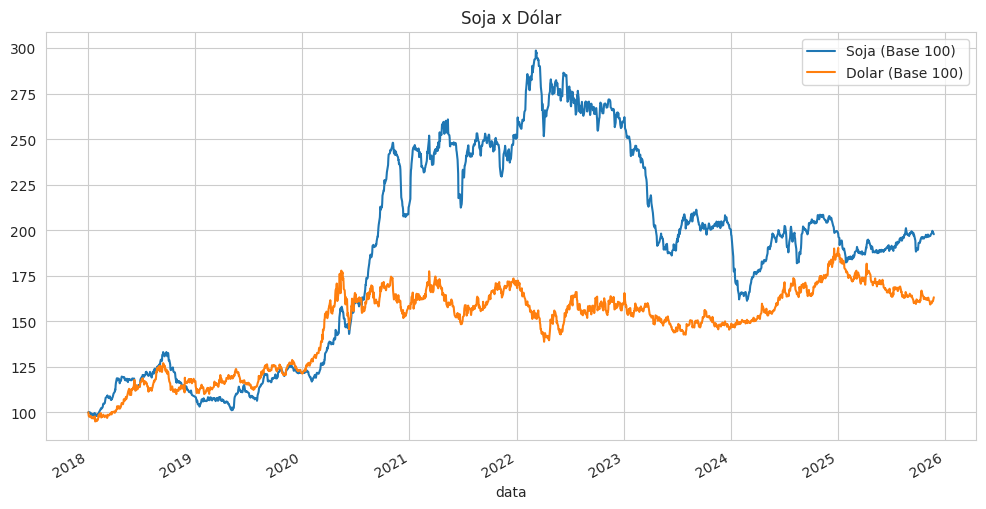

In [3]:
import pandas as pd
import os

# =============================================================================
# INGESTÃO DE DADOS: O "RESOLVEDOR UNIVERSAL"
# Contexto: O arquivo pode ser CSV real, CSV com cara de Excel, ou Excel real.
# Estratégia: Tentar todas as formas possíveis até abrir.
# =============================================================================

# 1. Encontrar o arquivo independente do nome maluco que ele tenha
arquivo_encontrado = None
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        # Pega qualquer coisa que tenha 'soja' no nome
        if 'soja' in file.lower():
            arquivo_encontrado = os.path.join(root, file)
            break

if arquivo_encontrado:
    print(f"🕵️ Arquivo detectado: {arquivo_encontrado}")
    
    df_soja = None
    sucesso = False

    # --- TENTATIVA 1: Ler como CSV (Separador Automático) ---
    if not sucesso:
        try:
            print("Tentando ler como CSV texto...")
            # 'sep=None' + 'engine=python' descobre se é virgula ou ponto-e-virgula sozinho
            df_soja = pd.read_csv(arquivo_encontrado, sep=None, engine='python', skiprows=3, on_bad_lines='skip')
            if df_soja.shape[1] > 1: # Se criou colunas, deu certo!
                sucesso = True
                print("✅ Sucesso: Lido como CSV!")
        except:
            print("⚠️ Falha na leitura CSV.")

    # --- TENTATIVA 2: Ler como Excel (Caso seja .xls real) ---
    if not sucesso:
        try:
            print("Tentando ler como Excel (Binário)...")
            df_soja = pd.read_excel(arquivo_encontrado, header=3)
            sucesso = True
            print("✅ Sucesso: Lido como Excel!")
        except:
             print("⚠️ Falha na leitura Excel.")

    # --- PROCESSAMENTO SE CARREGOU ---
    if sucesso and df_soja is not None:
        
        # 1. Limpeza de Colunas
        # Pega as duas primeiras colunas (Data e Preço)
        df_soja = df_soja.iloc[:, [0, 1]]
        df_soja.columns = ['data', 'preco_soja_brl']

        # 2. Tratamento de Data
        df_soja['data'] = pd.to_datetime(df_soja['data'], format='%d/%m/%Y', errors='coerce')

        # 3. Tratamento de Preço (Vírgula vira Ponto)
        if df_soja['preco_soja_brl'].dtype == object:
            df_soja['preco_soja_brl'] = df_soja['preco_soja_brl'].astype(str).str.replace(',', '.').astype(float)

        # 4. Remove vazios
        df_soja = df_soja.dropna(subset=['data', 'preco_soja_brl'])

        # --- MERGE FINAL ---
        df_dolar['data'] = pd.to_datetime(df_dolar['data'])
        if 'dolar_ptax' not in df_dolar.columns and 'Close' in df_dolar.columns:
             df_dolar = df_dolar.rename(columns={'Close': 'dolar_ptax'})

        df_final = pd.merge(df_soja, df_dolar, on='data', how='inner')
        df_final = df_final.sort_values('data')

        print(f"Base unificada com {df_final.shape[0]} linhas.")
        display(df_final.head())

        # Visualização
        df_norm = df_final.copy()
        if not df_norm.empty:
            df_norm['Soja (Base 100)'] = (df_norm['preco_soja_brl'] / df_norm['preco_soja_brl'].iloc[0]) * 100
            df_norm['Dolar (Base 100)'] = (df_norm['dolar_ptax'] / df_norm['dolar_ptax'].iloc[0]) * 100
            
            df_norm.plot(x='data', y=['Soja (Base 100)', 'Dolar (Base 100)'], 
                         title='Soja x Dólar', figsize=(12, 6))
    else:
        print("❌ Não foi possível ler o arquivo em nenhum formato conhecido.")

else:
    print("❌ Arquivo sumiu! Verifique o Upload.")

## 3. PREPARAÇÃO DOS DADOS (Engenharia de Atributos)


**Objetivo:** Criar as colunas analíticas (Features) para o Dashboard.

In [10]:
import numpy as np

# =============================================================================
# ETAPA 3: PREPARAÇÃO DOS DADOS (Engenharia de Atributos).
# =============================================================================


# 1. VARIAÇÕES PERCENTUAIS (Retorno Diário)
df_final['var_soja_pct'] = df_final['preco_soja_brl'].pct_change() * 100
df_final['var_dolar_pct'] = df_final['dolar_ptax'].pct_change() * 100

# 2. MÉDIAS MÓVEIS (Análise de Tendência)
# Suavização da série temporal para identificar tendências de médio prazo
df_final['media_movel_30d'] = df_final['preco_soja_brl'].rolling(window=30).mean()
df_final['media_movel_90d'] = df_final['preco_soja_brl'].rolling(window=90).mean()

# 3. CATEGORIZAÇÃO DE SAFRA (Sazonalidade Agrícola)
# Definição baseada no ciclo fenológico da soja no Centro-Sul do Brasil.
# - Jan/Fev: Desenvolvimento (Vegetativo/Reprodutivo) -> Expectativa de mercado.
# - Mar/Abr/Mai: Colheita (Choque de Oferta) -> Preços tendem a ceder devido ao volume físico.
# - Jun/Jul/Ago/Set: Entressafra (Escassez Relativa) -> Preços tendem a recuperar.
# - Out/Nov/Dez: Plantio (Risco Climático) -> "Mercado de Clima", alta volatilidade.

def definir_ciclo_safra(mes):
    if mes in [3, 4, 5]:
        return '3. Colheita (Oferta Alta)'
    elif mes in [6, 7, 8, 9]:
        return '4. Entressafra (Oferta Baixa)'
    elif mes in [10, 11, 12]:
        return '1. Plantio (Risco)'
    else:
        return '2. Desenvolvimento'

# Aplicando a categorização
df_final['mes'] = df_final['data'].dt.month
df_final['status_safra'] = df_final['mes'].apply(definir_ciclo_safra)

# Removendo dados iniciais sem média móvel para garantir integridade estatística
df_analitico = df_final.dropna().copy()

display(df_analitico[['data', 'preco_soja_brl', 'status_safra']].head(10))
display(df_analitico['status_safra'].value_counts().sort_index())

,data,preco_soja_brl,status_safra
89,2018-05-11,79.92,3. Colheita (Oferta Alta)
90,2018-05-14,80.57,3. Colheita (Oferta Alta)
91,2018-05-15,80.42,3. Colheita (Oferta Alta)
92,2018-05-16,79.63,3. Colheita (Oferta Alta)
93,2018-05-17,79.32,3. Colheita (Oferta Alta)
94,2018-05-18,80.29,3. Colheita (Oferta Alta)
95,2018-05-21,80.48,3. Colheita (Oferta Alta)
96,2018-05-22,80.33,3. Colheita (Oferta Alta)
97,2018-05-23,80.35,3. Colheita (Oferta Alta)
98,2018-05-24,80.11,3. Colheita (Oferta Alta)


status_safra
1. Plantio (Risco)               464
2. Desenvolvimento               283
3. Colheita (Oferta Alta)        450
4. Entressafra (Oferta Baixa)    685
Name: count, dtype: int64

## 4. Análise Visual e Validação de Hipóteses

A engenharia de dados foi concluída com sucesso. Agora temos a coluna status_safra devidamente preenchida e categorizada.

Agora vem a "cereja do bolo" da Análise de Dados: transformar esses números em Inteligência Visual. Vamos criar os gráficos que respondem às perguntas de negócio.

Vamos gerar dois gráficos:

1. Boxplot por Ciclo de Safra: Para provar estatisticamente se o preço realmente cai na colheita.

1. Mapa de Calor (Heatmap): Para ver o calendário de preços de forma intuitiva (o "semáforo" de preços).

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


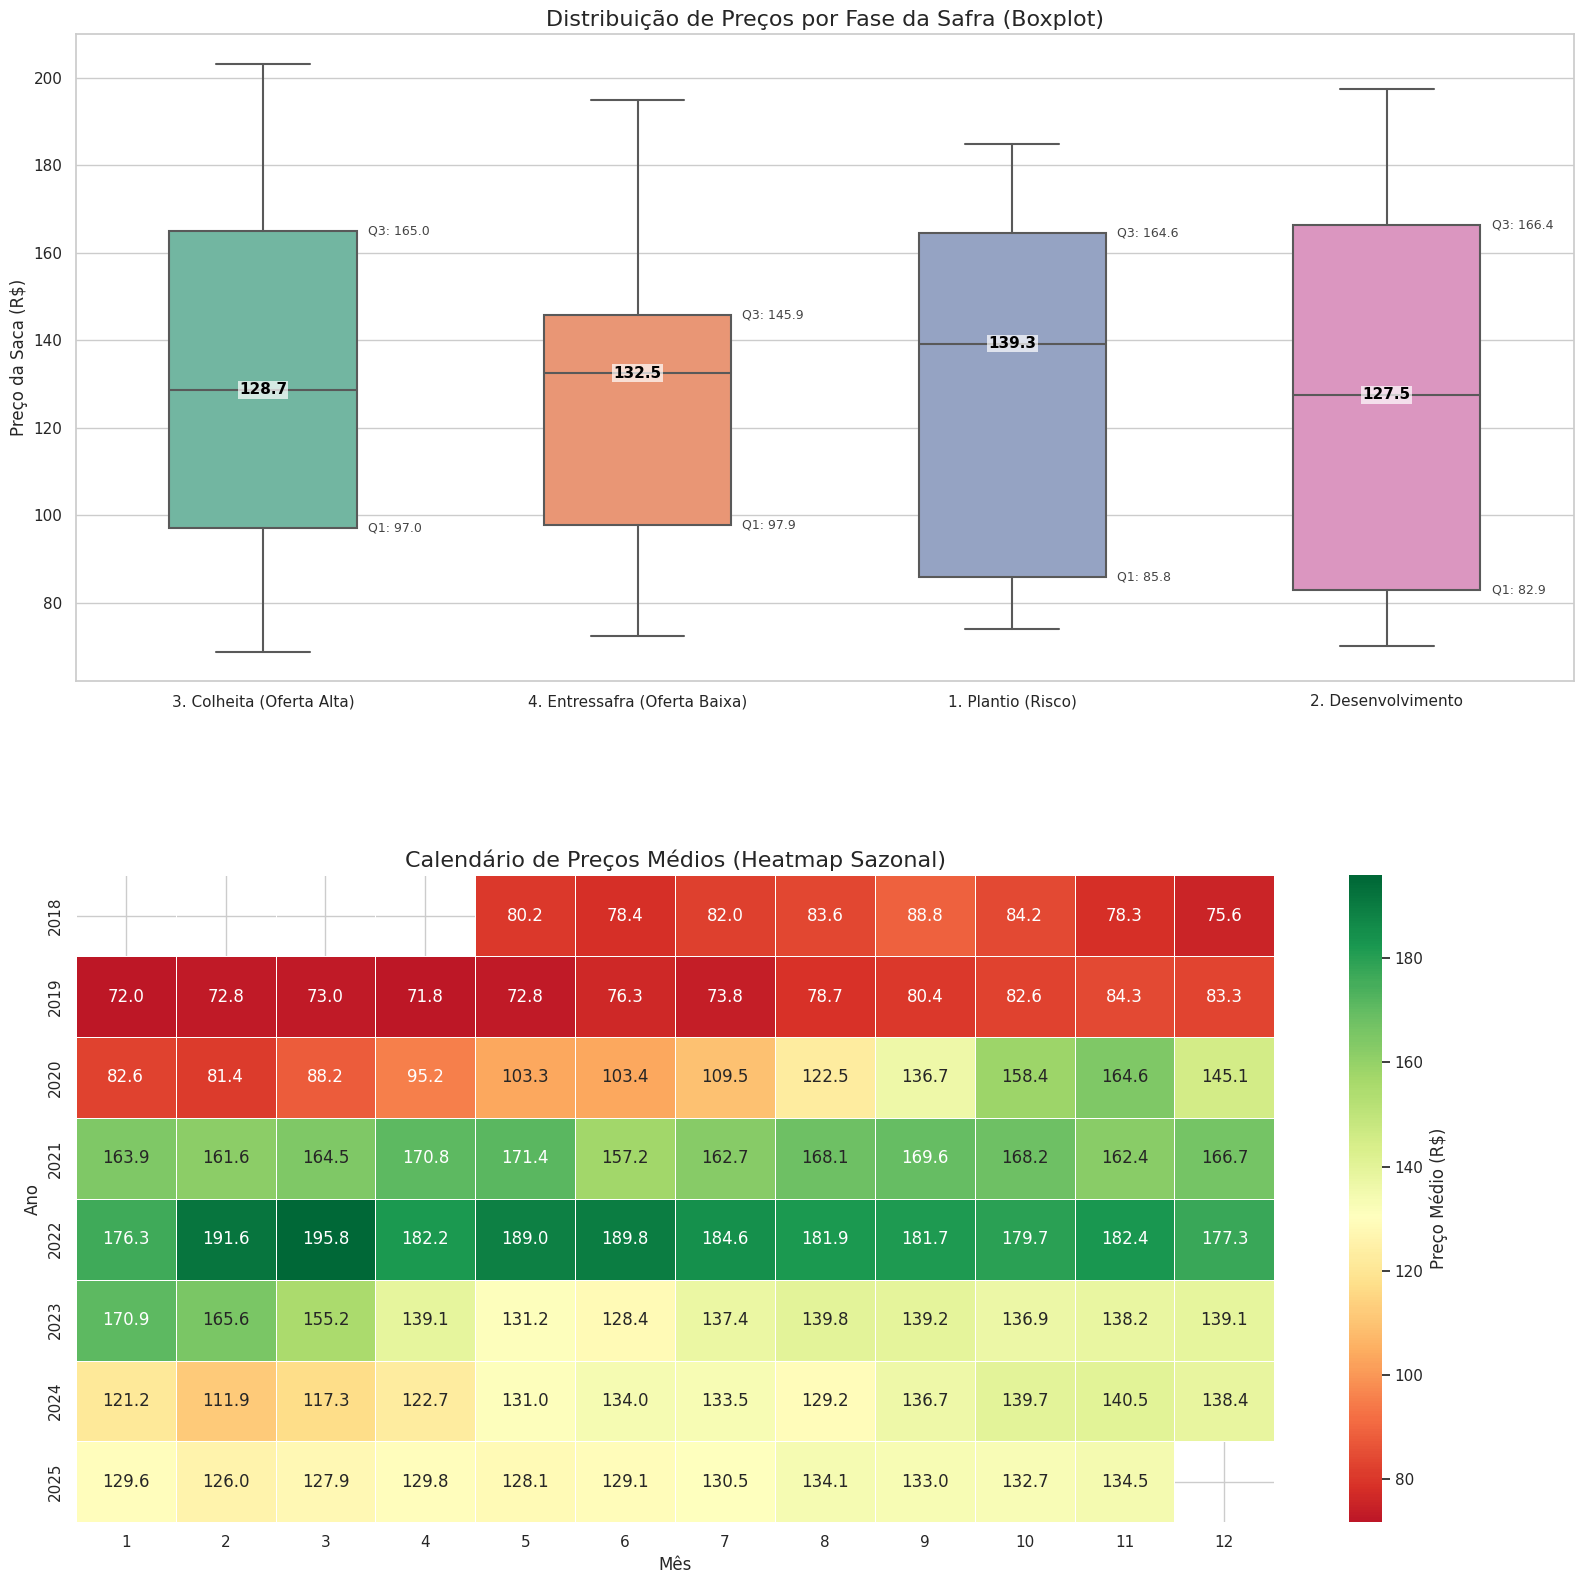

In [18]:
# =============================================================================
# ANÁLISE VISUAL ESTRATÉGICA 
# =============================================================================

# Configuração de Estilo
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(16, 16))

# --- GRÁFICO 1: DISTRIBUIÇÃO DE PREÇOS POR FASE DA SAFRA (BOXPLOT) ---
# Pergunta: "O preço realmente cai quando a oferta é alta (Colheita)?"
sns.boxplot(x='status_safra', y='preco_soja_brl', data=df_analitico, 
            ax=axes[0], palette="Set2", showfliers=False, width=0.5)

# Recupera as categorias ordenadas pelo eixo X do gráfico
labels_x = [item.get_text() for item in axes[0].get_xticklabels()]

for i, fase in enumerate(labels_x):
    dados_fase = df_analitico[df_analitico['status_safra'] == fase]['preco_soja_brl']
    
    if len(dados_fase) > 0:
        mediana = dados_fase.median()
        q1 = dados_fase.quantile(0.25)
        q3 = dados_fase.quantile(0.75)
        
        # 1. MEDIANA (No Centro, Negrito)
        # Usamos um 'bbox' branco suave para garantir leitura sobre qualquer cor
        axes[0].text(i, mediana, f'{mediana:.1f}', 
                     ha='center', va='center', fontweight='bold', color='black', fontsize=11,
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        # 2. QUARTIS (Na Lateral Direita - Padrão Fixo)
        # O offset (i + 0.28) garante que o texto fique logo ao lado da caixa, sem sobrepor
        # Q3 (Superior)
        axes[0].text(i + 0.28, q3, f'Q3: {q3:.1f}', 
                     ha='left', va='center', fontsize=9, color='#444444')
        
        # Q1 (Inferior)
        axes[0].text(i + 0.28, q1, f'Q1: {q1:.1f}', 
                     ha='left', va='center', fontsize=9, color='#444444')

axes[0].set_title('Distribuição de Preços por Fase da Safra (Boxplot)', fontsize=16)
axes[0].set_xlabel('', fontsize=12) # Removemos label X pois já é redundante
axes[0].set_ylabel('Preço da Saca (R$)', fontsize=12)

# --- GRÁFICO 2: MAPA DE CALOR DA SAZONALIDADE (HEATMAP) ---
# Pergunta: "Qual mês historicamente tem o menor preço?"
df_analitico['Ano'] = df_analitico['data'].dt.year
tabela_heatmap = df_analitico.pivot_table(values='preco_soja_brl', index='Ano', columns='mes', aggfunc='mean')

sns.heatmap(tabela_heatmap, cmap='RdYlGn', annot=True, fmt='.1f', 
            linewidths=.5, ax=axes[1], center=tabela_heatmap.mean().mean(), 
            cbar_kws={'label': 'Preço Médio (R$)'})

axes[1].set_title('Calendário de Preços Médios (Heatmap Sazonal)', fontsize=16)
axes[1].set_ylabel('Ano', fontsize=12)
axes[1].set_xlabel('Mês', fontsize=12)

# Ajustes Finais de Layout
plt.tight_layout()

# O 'hspace' define o espaço vertical entre os subplots (Aumente se quiser mais espaço)
plt.subplots_adjust(hspace=0.3) 

plt.show()

O Heatmap revela que, embora a sazonalidade exista (preços caindo na colheita), os Fatores Macroeconômicos (Câmbio e Demanda Global) são muito mais fortes. Em 2021/2022, a força da demanda foi tão grande que 'atropelou' a queda da colheita, mantendo o gráfico verde o ano todo.

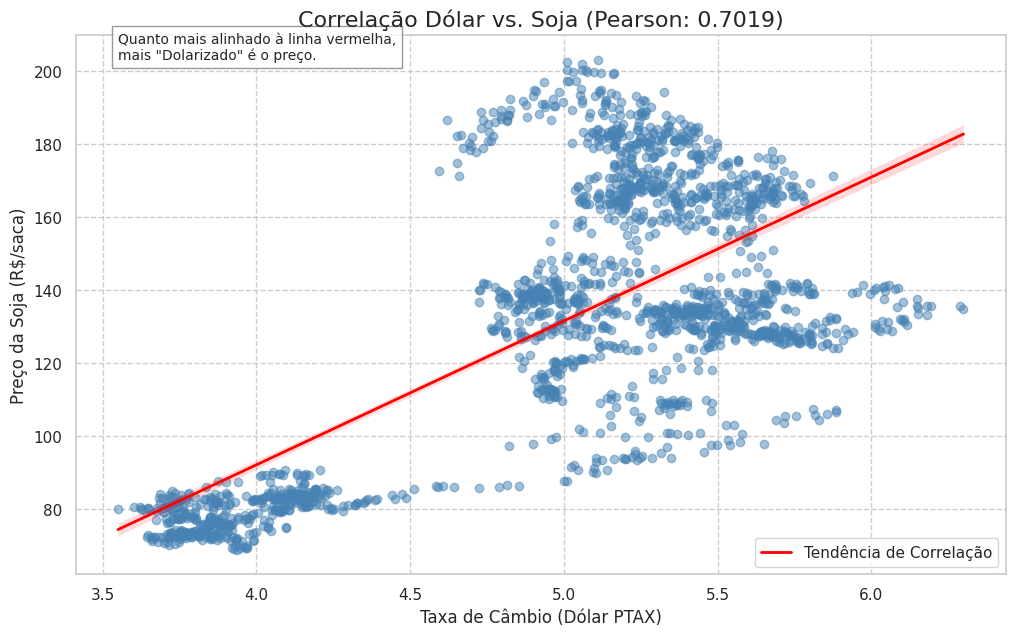

In [20]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# ANÁLISE DE CORRELAÇÃO (SCATTER PLOT COM REGRESSÃO LINEAR)
# Objetivo: Validar visualmente a força do vínculo estatístico entre Câmbio e Commodity.
# =============================================================================

# Configuração do Layout
plt.figure(figsize=(12, 7))

# Gráfico de Dispersão com Linha de Tendência
# O parâmetro 'label' é passado via dicionários (kws) para compor a legenda final
sns.regplot(x='dolar_ptax', y='preco_soja_brl', data=df_analitico, 
            scatter_kws={'alpha': 0.5, 'color': 'steelblue', 'label': 'Cotação Diária (Histórico)'}, 
            line_kws={'color': 'red', 'linewidth': 2, 'label': 'Tendência de Correlação'})

# Cálculo Estatístico (Coeficiente de Pearson)
corr, _ = pearsonr(df_analitico['dolar_ptax'], df_analitico['preco_soja_brl'])

# Elementos de Texto e Títulos
plt.title(f'Correlação Dólar vs. Soja (Pearson: {corr:.4f})', fontsize=16)
plt.xlabel('Taxa de Câmbio (Dólar PTAX)', fontsize=12)
plt.ylabel('Preço da Soja (R$/saca)', fontsize=12)

# Adicionando anotação de negócio para facilitar a interpretação
plt.text(df_analitico['dolar_ptax'].min(), df_analitico['preco_soja_brl'].max(), 
         'Quanto mais alinhado à linha vermelha,\nmais "Dolarizado" é o preço.', 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Renderização da legenda
plt.legend(loc='lower right', frameon=True, fontsize=11)

plt.grid(True, linestyle='--')
plt.show()

/tmp/ipykernel_47/2519001503.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts = df_ts.fillna(method='ffill')


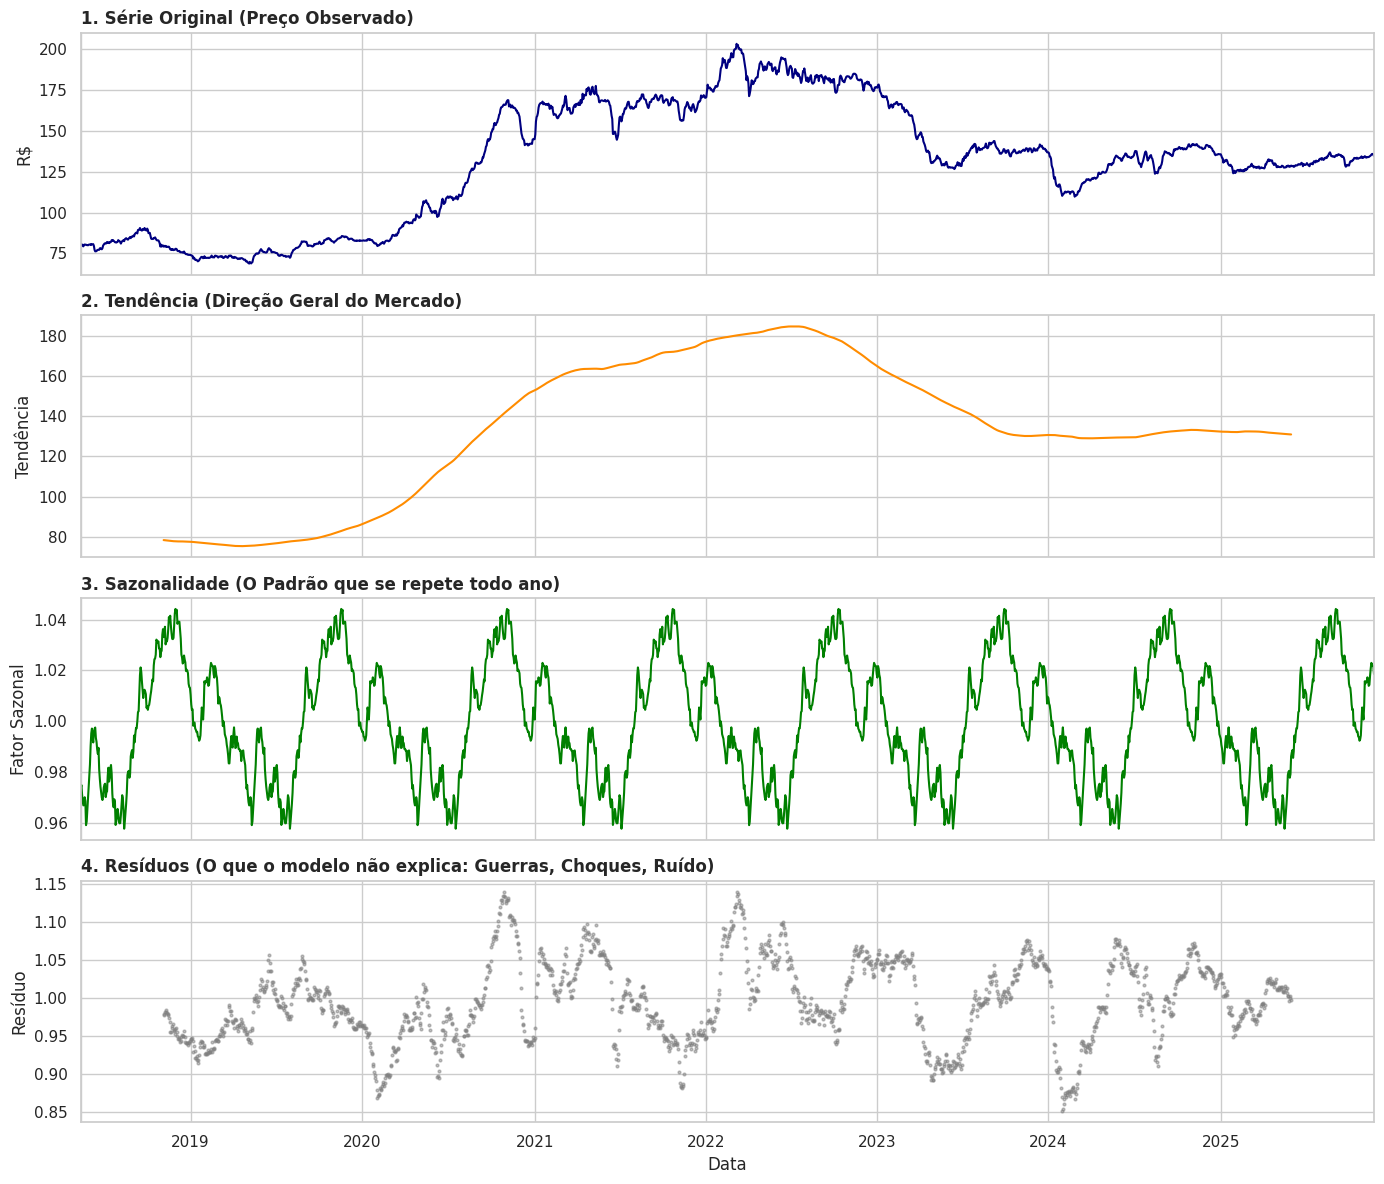

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# =============================================================================
# ANÁLISE DE TENDÊNCIA E SAZONALIDADE (DECOMPOSIÇÃO CLÁSSICA)
# Objetivo: Separar matematicamente o que é Tendência, Sazonalidade e Ruído.
# =============================================================================

# 1. Preparação: O Statsmodels exige que o Index seja a Data e que não haja buracos (frequência fixa)
df_ts = df_analitico.set_index('data')['preco_soja_brl'].asfreq('B') # 'B' = Business Days (Dias Úteis)

# Preenchendo pequenos buracos (feriados) com o valor anterior para não quebrar o cálculo
df_ts = df_ts.fillna(method='ffill')

# 2. Decomposição (Modelo Multiplicativo é melhor para preços que mudam de patamar)
# period=252 (Aprox. dias úteis em um ano)
resultado = seasonal_decompose(df_ts, model='multiplicative', period=252)

# 3. Plotagem
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Original
resultado.observed.plot(ax=ax1, color='navy')
ax1.set_title('1. Série Original (Preço Observado)', loc='left', fontsize=12, fontweight='bold')
ax1.set_ylabel('R$')

# Tendência (Trend)
resultado.trend.plot(ax=ax2, color='darkorange')
ax2.set_title('2. Tendência (Direção Geral do Mercado)', loc='left', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tendência')

# Sazonalidade (Seasonal)
resultado.seasonal.plot(ax=ax3, color='green')
ax3.set_title('3. Sazonalidade (O Padrão que se repete todo ano)', loc='left', fontsize=12, fontweight='bold')
ax3.set_ylabel('Fator Sazonal')

# Resíduo (Residual)
resultado.resid.plot(ax=ax4, color='gray', linestyle='None', marker='o', markersize=2, alpha=0.5)
ax4.set_title('4. Resíduos (O que o modelo não explica: Guerras, Choques, Ruído)', loc='left', fontsize=12, fontweight='bold')
ax4.set_ylabel('Resíduo')

plt.xlabel('Data')
plt.tight_layout()
plt.show()

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# =============================================================================
# ETAPA 6: DASHBOARD INTERATIVO (PROTÓTIPO PLOTLY)
# Ferramenta: Plotly (Ideal para notebooks, permite zoom e hover)
# =============================================================================

# 1. CÁLCULO DOS KPIS (CARTÕES DE TOPO)
ultimo_dado = df_analitico.iloc[-1]
preco_atual = ultimo_dado['preco_soja_brl']
dolar_atual = ultimo_dado['dolar_ptax']
var_mes = ultimo_dado['var_soja_pct'] # Variação do último dia (exemplo)

# Variação acumulada no mês atual (Cálculo mais robusto)
ultimo_mes = df_analitico[df_analitico['data'].dt.month == df_analitico['data'].iloc[-1].month]
var_acumulada_mes = ((ultimo_mes['preco_soja_brl'].iloc[-1] / ultimo_mes['preco_soja_brl'].iloc[0]) - 1) * 100

print(f"--- [KPIs] RESUMO EXECUTIVO ({ultimo_dado['data'].strftime('%d/%m/%Y')}) ---")
print(f"💰 Preço Soja: R$ {preco_atual:.2f} / saca")
print(f"💵 Dólar PTAX: R$ {dolar_atual:.4f}")
print(f"📈 Variação no Mês: {var_acumulada_mes:+.2f}%")
print("-" * 50)

# 2. CONSTRUÇÃO DO DASHBOARD GRÁFICO
# Criando uma figura com subplots (2 linhas: Principal em cima, Secundário em baixo)
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.15,
    subplot_titles=("Evolução Diária: Preço da Soja (Eixo Esq) vs Dólar (Eixo Dir)", 
                    "Sazonalidade: Mapa de Calor de Preços (Mês x Ano)"),
    specs=[[{"secondary_y": True}], [{"type": "heatmap"}]] # Define que o 1º gráfico tem eixo duplo
)

# --- GRÁFICO PRINCIPAL: LINHA DO TEMPO (PREÇO X DÓLAR) ---
# Linha da Soja (Azul)
fig.add_trace(
    go.Scatter(x=df_analitico['data'], y=df_analitico['preco_soja_brl'], name="Preço Soja (R$)",
               line=dict(color='#1f77b4', width=2)),
    row=1, col=1, secondary_y=False
)

# Linha do Dólar (Laranja) - Eixo Secundário
fig.add_trace(
    go.Scatter(x=df_analitico['data'], y=df_analitico['dolar_ptax'], name="Dólar (R$)",
               line=dict(color='#ff7f0e', width=2, dash='dot')), # Tracejado para diferenciar
    row=1, col=1, secondary_y=True
)

# --- GRÁFICO SECUNDÁRIO: HEATMAP (SAZONALIDADE) ---
# Preparando matriz para o Plotly
heatmap_data = df_analitico.pivot_table(values='preco_soja_brl', index='Ano', columns='mes', aggfunc='mean')

fig.add_trace(
    go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='RdYlGn', # Vermelho (Baixo) -> Verde (Alto)
        colorbar=dict(title='Preço Médio (R$)', len=0.5, y=0.2), # Ajuste da barra de cores
        hovertemplate='Ano: %{y}<br>Mês: %{x}<br>Preço Médio: R$ %{z:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# 3. LAYOUT E ESTILIZAÇÃO
fig.update_layout(
    title_text="<b>Dashboard Estratégico: Dinâmica do Agronegócio</b>",
    height=900, # Altura total
    template="plotly_white",
    hovermode="x unified", # Tooltip mostra todos os dados daquela data juntos
    legend=dict(orientation="h", y=1.02, x=0.5, xanchor="center") # Legenda no topo
)

# Ajuste dos Eixos Y do gráfico principal
fig.update_yaxes(title_text="<b>Preço Soja (R$)</b>", row=1, col=1, secondary_y=False)
fig.update_yaxes(title_text="<b>Cotação Dólar</b>", row=1, col=1, secondary_y=True, showgrid=False)
fig.update_xaxes(title_text="Mês do Ano", row=2, col=1, tickmode='linear', tick0=1, dtick=1)

fig.show()

--- [KPIs] RESUMO EXECUTIVO (24/11/2025) ---
💰 Preço Soja: R$ 134.58 / saca
💵 Dólar PTAX: R$ 5.4021
📈 Variação no Mês: +68.48%
--------------------------------------------------


In [25]:
# Salvando
df_analitico.to_csv('soja_dashboard_final.csv', index=False)
print("Arquivo salvo! Procure na aba Output para baixar.")

Arquivo salvo! Procure na aba Output para baixar.
